In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cProfile
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pstats
import sys
import tifffile as tf
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append("../")
from data_prep import collect, load, draw, save, image
from data_prep.image import Image
from data_prep.interp import SphericalSampler
from solvers import branch_classifier
import models
DATE = datetime.now().strftime("%m-%d-%y")
DTYPE = torch.float32
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/bgray/anaconda3/envs/neurotrack/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# choose an image and load it
img_dir = "/nafs/dtward/bryson/gold166_tifs_scaled/"
swc_dir = "/nafs/dtward/bryson/gold166_swc_scaled/"
img_list = sorted(os.listdir(img_dir))
swc_list = sorted(os.listdir(swc_dir))

i = 0
img_path = os.path.join(img_dir, img_list[i])
swc_path = [d for d in swc_list if d.split('.')[0] == img_list[i].split('.')[0]][0]
swc_path = os.path.join(swc_dir, swc_path)

print(img_path)
print(swc_path)




/nafs/dtward/bryson/gold166_tifs_scaled/0661_seg.tif
/nafs/dtward/bryson/gold166_swc_scaled/0661_seg.v3dpbd.swc


In [4]:
# get the branch points from the image

swc_list = load.swc(swc_path)
sections, section_graph = load.parse_swc(swc_list)
branches, terminals = load.get_critical_points(swc_list, sections)

img = tf.imread(img_path)
img = Image(img[None])
# choose a branch point
branch_id = 0
# load a large image patch centered on a branch point
center = branches[branch_id, :3]
large_patch, _ = img.crop(center, radius=49)

loading file: /nafs/dtward/bryson/gold166_swc_scaled/0661_seg.v3dpbd.swc


In [5]:
# load model
classifier = models.ResNet2D(models.ResidualBlock2D, [3, 4, 6, 3], in_channels=36, num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=DTYPE)

weights = "/nafs/dtward/bryson/gold166_classifier_data/training_output_03-28-25_spherical_patches/resnet_classifier_03-29-25_checkpoint-30.pt"
state_dict = torch.load(weights, map_location=DEVICE)
classifier.load_state_dict(state_dict)
print(f"Loaded pretrained weights from {weights}")

Loaded pretrained weights from /nafs/dtward/bryson/gold166_classifier_data/training_output_03-28-25_spherical_patches/resnet_classifier_03-29-25_checkpoint-30.pt


In [6]:
resolution = (180,360)
permutations = [[-3,-2,-1],
                [-3,-1,-2],
                [-2,-1,-3],
                [-2,-3,-1],
                [-1,-3,-2],
                [-1,-2,-3]]
radii = torch.arange(3,34,6)
# initialize spherical sampler
patch_radius = int(torch.amax(radii) + 1)
patch_shape = (patch_radius*2+1,) * 3
spherical_sampler = SphericalSampler(input_shape=patch_shape, radii=radii, resolution=resolution)

In [7]:
Iout = np.zeros_like(large_patch)

for i in tqdm(range(34, 65), desc="Processing points"):
    for j in range(34, 65):
        for k in range(34, 65):
            point = np.array((i, j, k))
            patch = img.crop(point, radius=patch_radius)[0]
            spherical_patches = []
            for perm in permutations:
                patch_perm = patch.permute(0, *perm)
                spherical_patch = spherical_sampler.map_coordinates(patch_perm[None]) # output shape (N,len(radii),1,H,W)
                spherical_patches.append(spherical_patch.squeeze(2))
            spherical_patches = torch.cat(spherical_patches, dim=1)
            spherical_patches = spherical_patches.to(DEVICE)
            out = classifier(spherical_patches)
            out = torch.sigmoid(out.squeeze())
            Iout[0, i, j, k] = out.item()

Processing points:   0%|          | 0/31 [00:00<?, ?it/s]

Processing points: 100%|██████████| 31/31 [29:33<00:00, 57.22s/it]


# view image with true branches

In [8]:
segments = []
for section in sections.values():
    segments.append(section)
segments = np.concatenate(segments)

density = draw.draw_neuron_density(segments, img.data.shape[1:], scale=1.0)
mask = draw.draw_neuron_mask(density, threshold=5.0)

branch_mask = Image(torch.zeros_like(mask))
for point in branches:
    r = point[3].item() #/ xy_scale
    branch_mask.draw_point(point[:3], radius=r, binary=True, value=1, channel=0)
branch_mask_patch = branch_mask.crop(center, radius=49)[0]

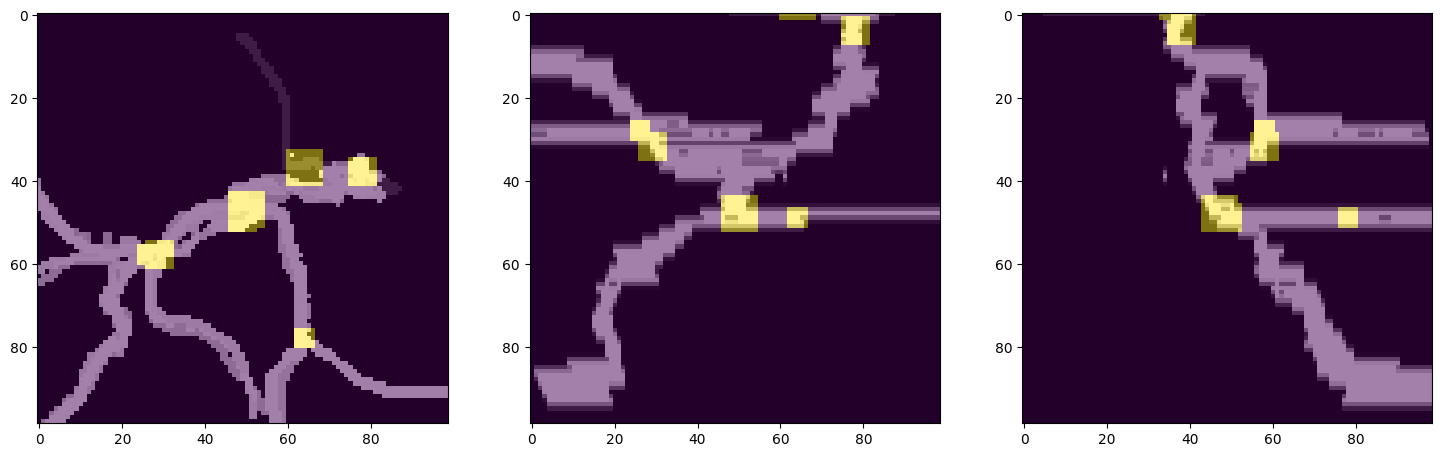

In [9]:
fig, ax = plt.subplots(1,3, figsize=(18,18))
ax[0].imshow(large_patch[0].amax(0), cmap='gray')
ax[0].imshow(branch_mask_patch[0].amax(0), alpha=0.5)
ax[1].imshow(large_patch[0].amax(1), cmap='gray')
ax[1].imshow(branch_mask_patch[0].amax(1), alpha=0.5)
ax[2].imshow(large_patch[0].amax(2), cmap='gray')
ax[2].imshow(branch_mask_patch[0].amax(2), alpha=0.5)

# view image with classifier output

array([0.43916544], dtype=float32)

In [15]:
np.unique(Iout)

array([0.        , 0.43916544], dtype=float32)

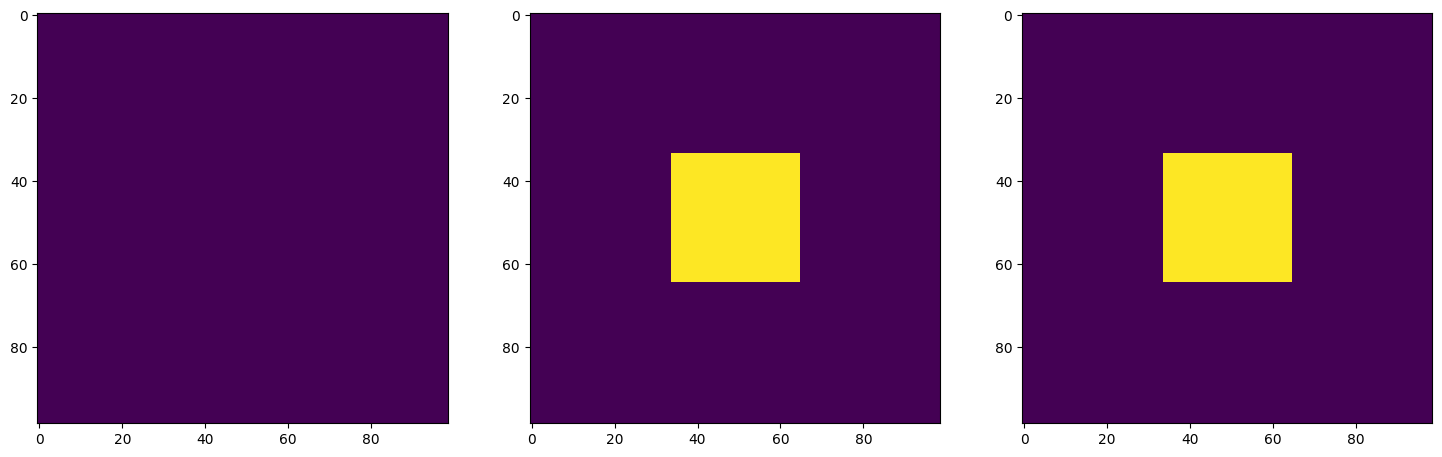

In [30]:
fig, ax = plt.subplots(1,3, figsize=(18,18))
# ax[0].imshow(large_patch[0].amax(0), cmap='gray')
ax[0].imshow(Iout[0,33], vmin=0.0, vmax=Iout.max())#alpha=0.5)
# ax[1].imshow(large_patch[0].amax(1), cmap='gray')
ax[1].imshow(Iout[0,:,49], vmin=0.0, vmax=Iout.max())#alpha=0.5)
# ax[2].imshow(large_patch[0].amax(2), cmap='gray')
ax[2].imshow(Iout[0,:,:,49], vmin=0.0, vmax=Iout.max())#alpha=0.5)